In [9]:
import os

image_list = []
root = "./Product/Validation/label/"
category = []

for dir in os.listdir(root):
    os.rename(root + dir, root + dir.split("_")[0])

In [14]:
import os

image_list = []#glob(u'./상품 이미지/Validation/[원천]유제품/10246_토핑오트_애플시나몬/*.jpg')

root = "./Product/Training/image/"
category = []
categories = {}
for dir in os.listdir(root):
    for file in os.listdir(root + dir):
        if file.endswith(".jpg"):
            # image_list += os.path.join("/mydir", file)
            image_list.append(os.path.join(dir, file).replace("\\","/"))
    category.append(dir)
# image_list
# for (i, cat) in zip(range(len(category)), category):
#     print(i, cat)
print(category)
categories = {cat:i for (i, cat) in zip(range(len(category)), category)}
category = [{"id": i, "name":cat} for (i, cat) in zip(range(len(category)), category)]

from sklearn.model_selection import train_test_split
train_img_list, val_img_list = train_test_split(image_list, test_size=0.2, random_state=2000)
# val_img_list, t = train_test_split(val_img_list, test_size=0.9, random_state=2000)

with open('./Product/Training/train.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(train_img_list) + '\n')
    
with open('./Product/Training/test.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(val_img_list) + '\n')

['10246', '10247', '10248', '10249', '10250', '10252', '10253', '10254', '10256', '10257', '10259', '15122', '15126', '15128', '15129', '15130', '15131', '15132', '15134', '15139', '15142', '15143', '15144', '15184', '15185', '15186', '15187', '15188', '15189', '15190', '15191', '15193', '15194', '15195', '15196', '15208', '15209', '15210', '15211', '15212', '15213', '15214', '15215', '15216', '15217', '15218', '15219', '15222', '15343', '15876', '15877', '15880', '20061', '20240', '20243', '20245', '20246', '20247', '20248', '20249', '20250', '20251', '25122', '25123', '25124', '25125', '25126', '25127', '25128', '25129', '25155', '25156', '25157', '25158', '25160', '25161', '25162', '25169', '25177', '25196', '25208', '25210', '25238', '25239', '25244', '30208', '30209', '30210', '30211', '30212', '30213', '30214', '30215', '30216', '30217', '30218', '30219', '35024', '35061', '35075', '35117', '35118', '35126', '35127', '35128', '35129', '35131', '35132', '35133', '35134', '35135', 

In [11]:
import os

image_list = []

root = "./Product/Validation/image/"
# category = []
for dir in os.listdir(root):
    for file in os.listdir(root + dir):
        if file.endswith(".jpg"):
            # image_list += os.path.join("/mydir", file)
            image_list.append(os.path.join(dir, file).replace("\\","/"))
    # category.append(dir)
# len(category)
# category = [{"id": i, "name":cat} for (i, cat) in zip(range(len(category)), category)]

with open('./Product/Validation/val.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(image_list) + '\n')

In [18]:
import os.path as osp
import mmcv
import json
import xmltodict

# CLASSES = ('traffic_light', 'traffic_sign', 'traffic_information')
# cat2label = {k: i for i, k in enumerate(CLASSES)}
# categories = {"치즈" : 0, "요구르트": 1, "우유":2, "레저취미":3, "버터":4}

def convert_data_to_coco(ann_file, out_file, image_prefix):
    global categories
    global category
    data_infos = mmcv.list_from_file(ann_file)
    annotations = []
    images = []
    
    idx = -1
    obj_count = 0
    last_category_id = 0
    for filename in data_infos:
        idx += 1
        
        img_path = osp.join(image_prefix, filename)
        
        height, width = mmcv.imread(img_path).shape[:2]
        
        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))
        with open((img_path[:-4] + "_meta.xml").replace("image", "label"), 'rt', encoding="UTF-8") as f:
            dic = json.loads(json.dumps(xmltodict.parse(f.read())))['comp_cd']
    
        bboxes = []
        labels = []
        masks = []
        
        if dic['div_cd']['div_m'] not in categories.keys():
            categories[dic['div_cd']['div_m']] = last_category_id
            last_category_id += 1
        elif "object" not in dic['annotation'].keys():
            continue
        objs = dic['annotation']['object']
        if type(objs) != list:
            objs = [objs]
        for obj in objs:
            box = [int(obj['bndbox']["xmin"]), int(obj['bndbox']["ymin"]), 
                   int(obj['bndbox']["xmax"]) - int(obj['bndbox']["xmin"]), int(obj['bndbox']["ymax"]) - int(obj['bndbox']["ymin"])]
            
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=categories[dic['div_cd']['item_no']],
                bbox=box,
                area=height * width,
                segmentation=[[]],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1
            
    # categories = [{"id": 0, "name": "Cheese"}, {"id": 1, "name": "Yogurt"}, {"id": 2, "name": "Milk"}, {"id": 3, "name": "Hobbies"}, {"id": 4, "name": "Butter"}]
    # return
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=category)
    # 확인용
    print(json.dumps(coco_format_json, indent = 4, sort_keys = True, ensure_ascii=False))
    # with open(out_file, 'w', encoding='utf-8') as f:
    #     json.dump(coco_format_json, f, ensure_ascii=False, indent = 4, sort_keys = True)
    mmcv.dump(coco_format_json, out_file)
    
convert_data_to_coco('./Product/Validation/val.txt',
                        './Product/Validation/annotation_coco_val.json',
                        './Product/Validation/image')

convert_data_to_coco('./Product/Training/test.txt',
                        './Product/Training/annotation_coco_test.json',
                        './Product/Training/image')

convert_data_to_coco('./Product/Training/train.txt',
                        './Product/Training/annotation_coco_train.json',
                        './Product/Training/image')



{
    "10246": "요구르트",
    "10247": "우유",
    "10248": "우유",
    "10249": "요구르트",
    "10250": "요구르트",
    "10252": "우유",
    "10253": "요구르트",
    "10254": "요구르트",
    "10256": "요구르트",
    "10257": "요구르트",
    "10259": "요구르트",
    "15122": "요구르트",
    "15126": "치즈",
    "15128": "버터",
    "15129": "치즈",
    "15130": "요구르트",
    "15131": "요구르트",
    "15132": "요구르트",
    "15134": "요구르트",
    "15139": "요구르트",
    "15142": "요구르트",
    "15143": "요구르트",
    "15144": "요구르트",
    "15184": "치즈",
    "15185": "요구르트",
    "15186": "요구르트",
    "15187": "요구르트",
    "15188": "요구르트",
    "15189": "요구르트",
    "15190": "요구르트",
    "15191": "요구르트",
    "15193": "요구르트",
    "15194": "우유",
    "15195": "우유",
    "15196": "우유",
    "15208": "우유",
    "15209": "우유",
    "15210": "우유",
    "15211": "우유",
    "15212": "우유",
    "15213": "우유",
    "15214": "우유",
    "15215": "우유",
    "15216": "우유",
    "15217": "요구르트",
    "15218": "우유",
    "15219": "우유",
    "15222": "요구르트",
    "15343": "치즈",
    "15876": 

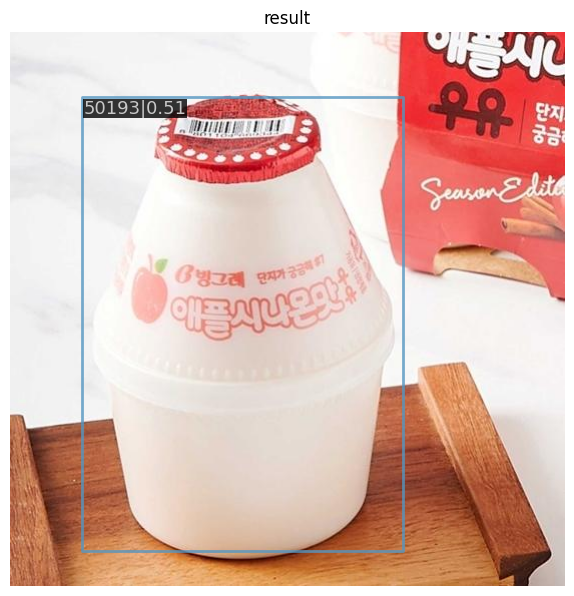

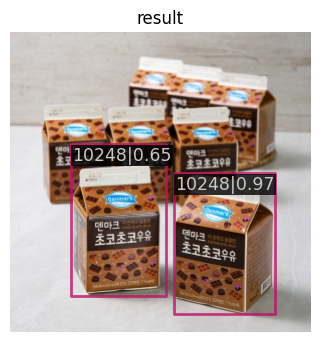

In [65]:
import torch
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
PATH = './weights/'
device = torch.device("cuda")
model = torch.load(PATH + 'model.pt')
model.to(device)

img = mmcv.imread('./test.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.4)#score_thr

img = mmcv.imread('./TestImage/TestImage05.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)#score_thr

# img = mmcv.imread('./TestImage/TestImage02.jpg')
# result = inference_detector(model, img)
# show_result_pyplot(model, img, result, score_thr=0.4)#score_thr

# img = mmcv.imread('./TestImage/TestImage07.jpg')
# result = inference_detector(model, img)
# show_result_pyplot(model, img, result, score_thr=0.5)#score_thr


In [40]:
data="/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAEsASwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2MLg04ntnmnM3Tiozy2askcrDGCeaeHBOBUAyCcgVJGwPUYoAkYNtOME9qRQSq7gM96dvHOaaWGMikAGJT9aTy8dKQSg4IzilMnPJoAQDnmkz1pQRknNB5piEYFgOmKYYFxyM052CDk0wTKWxyKAFEQUYA2ilZFHJx9aaGLNkciguMc0ANSMK7PnrTmA7AGopZABnBwKUNkjJwKAEkAI6c9qrjOSGBz61O5XdxmoJJArdSM00DELHGMmombBOCaGlyPlPH0qJ5UXhm5+lUSPZznhuKQH3zVeeZNmc1EswbHOBRYC8WOe2KRsHviq4lTHXigSA9KQyU5ApnmdcjFRiTqOtMeUgYwMmgBzSsDkChbrdkMMYqNWYfeGfSoXkLMQVAGfzosK5K0vUHJBqEyDPpQ8yqcelQtIsh47UWAmMuKY05B4FNLgdxSO649aLAEkjs2QKasr91pSykDrTQOTg8UmMkWTcSCMYoJJ6Cm7eKdj0qWMjbfxxTSGzUjA57U0k+lIDuAc9c0oXjrTcHoWppbB9RVDJsKRg5pEwMjBpm7p1qXt1oADt9Kapz/DTuKbkE0CA8HgVCzgkg9akJH1qJsF+flxQgFQ7ux4p28gcDNMXb0yTT9o2jApgJkNywyajbGSSpAqZRgEd6a2e9AEPTuRUcb7I/mJ61Nnj5lxSNimIi3pICozSggYGelOwO2M0wrkdaBgWBz/OmEjHvXXadpFq1jG8sYZmGSSabJoVlJ90MufQ1Nx2OLkKg8sAfSq7hWOQQa7KTwtbschmz71Wfwpj7kw/EU+ZE2ZyTxhhg7apywyc4AArsZPClxnKTRn8KxdX0m405lE2CrdCOlNSBoxfJfHI/I0iROAcNj6mrQVQcc01oYiOQc+tVckrYlztBOfrShZgckmmTWabgVd/zo+zRnnc/wCdAE3mz5zgY96fK/yAlQW9qrrbBuGZwv1oexUDKs2PrS0GOIRxkoRmmmJQcK1CWqjJ3N+dRtabjmOQrQAsiqOpJxTSyEdxioJFuYTlmV0zUjISu9W4NACyMQuVzUAkcvj5hUm526DihvlH3sGkA0vIvc1OrMVGTzVSVJlBYMCOtQLcPn5mFFrhc0GkK5JNQ+a+eWFZ891KCdrCqpv5cnkflRyhc9VbluppUIJxzmpDtUfeoVkByD1pFiZyRkHIpSx7Cm7gxJzzUgxnANIBhJYYINNYbSOKlJAPWopWwc0CJgB60xwCeRxTBKTkBelIZCW54xTsBIoBBxjNJyq4zzTTIew/Kmhs8k0WYXLAbjmms4NQsdhFIXUtzRYB7MMckUw4PTpTXKE5AyKbgdhg0xEgVTkk1H8qA5OB60gBycnGKxfEt3c2tk7WUXnS9lz1rWjSdWfKiKk1CPMekadq2kzwpDFfxb0ABXeMitKJrc42To3/AAKvn/w895rCSLLavZzudpYdfqK9A0Hwh/Z8YM95dXAY5LE81ti6FDDW5p2v5GeHq1a1+WOx6OOejKfxoIbsAa5htAgdCbfULuKTtlyK5TXtS1nSVMUN9IrD7shw2a56NGFd2pSuzarUdFXmtD1A5AOVrO1CC3uVUXMauoPA615x4Y+JMtxerb6oJ0gQHzJ3jwCa7211XRdQTzLa/jYN/tYqqmEqUnqhQrQnsyu+gafMx2xYPscVXk8K2jdDIv410ET27D91cRt9GqULn7rg/Q1g7o0VmcfN4SjOdk7D6is4+Dp43Jjuty/3SK9BZZB2zUUi5TaVwfWhSYOKPLtVsbjT5RFIudwyD2NUXZ1CivSL+2jm5nRZNvTPas19LsZMfuME8DFUmTY4nD8cjFNP3sdvUV2z+HrXtG4/Gq7+HIOqySKfcUrhY451DPg8rQYl298V00/h1gMxyqT2yKpNoOoKjsBEcDOM8mi4WMIxYHXFRG2V26k+tWtkufmUAinJGQTkdetFwsVDChT7xP1qiIA85jOQOxFbBRSeRSBAOdvSjmCxnnS4+fmNNOkxH+I1pM2DzUbS88KaXMwsjtVmyMFQKj82MybSMGpBGpGckkVACvnYK/MaoZOrxdBjNOyp5HBpkUCAk45NSCEdKWgCoMnk5pHUbsYyKiI2H7xzSozlxjmgB4UelOVVOcjmnElTz1ppkGeozSAbsXJOAKZtA4ApXmHJyMUwTBuegqgHFST0qB0y33eKk80E9TS7+uKYiAgDApWYDrTy56ACmFB6cUARXE0UcTSTSLHEOWZjwBVC/wBLXVFU6frlr5LD+BgT/OqXj0f8UfqpHB8hq8S+EvhnQtf0e6k1PUp7e8hckhJCu1ccV0Uans1zIznBTdmfQ1hpN7aT26W7xy7R80pIya76xu2WBUniyQMcc5r5on8E6jpzW0mj+MbxYJJBHnzSduenT61yOreOvGfhvXLvTU8QtcG2cJvbkNxnPNOo/rPxDglRWh9X+JNSe0t/NtbG4ldT92I4zXA6++oXEq3DWUoVudjfwV4vB8ZvG8TKPtVvN9YxzXd/D74ma34nurmz1+402zj2YRmG0ux9MmtMJSjh580YmeIn7aPK2QeJL7VdOjj+yWa3ERPz56/TFa+iadceIYIIjJPp+75mCdR7VcHhjU7q8SZ9ZtniVs7IsfMK3vD0OqWepSf6Oq26nOcg7q9KtiE6bVN69DjhQbqJz2W5t6V4Zhs4khuZrlsKBvAzn8qt3PhhDGZLDVLlHUZ2lyK3YtVt5Iv30JDem2uX8U+JI9Mlha3tL+YSHYRENw/HNfOe1x3N3PXVPDW00MDWtb1ixwkWoSQNHksWXduHtVLTfilNcXkFuBcSoSFeUw4A96xtevLx73fNaTsG6Ej7oPasi8vL3T9OkmitluH/AIURduPrX0kcLCUE5JXPI9rJX19D2y01nQNUfEeooZRwVzg5rRhhtAoEN3G3plq+d/DmsS6rDMFtZLSbkM4GBn2r0Hw/4RubSLzrnUbu6ViDnZkj6V5mMoUMMuac7JnXh6tWs3GMbtHp4t2/hlDfQ0jRTD7oJrml0C2mXEer3MLkY+YFOfxrI1ZdW8Oltt/PPE3KtndiuOiqNd2pTTZ01OekrzidthwSXiB/Cqz4Bd9pxg8V5YPiPf6RLjVb8TK/KKkXNN1X4uyQ6JdXaQAeWMYkj259K3lgqkdzJYiD1Rp3DHzXPfcaZuODXJeCvGMHia33ZWO7HLx5/lXV81zSg4uzNE77CdzkCjccdKQtj8aQyYHTNTYAcjOdvNRHJPA4p+8HqM03cO2aAO1VkCiggEltoPpTkCnI4pwVBTKGK31Gal+6oGSKQbRwKU4zSERbCZBuORT174I+tW44lMQYruzUTS28TbCqBicYPrRuK5UkJyCWwB1pwKMV759qspLHMzIkaEjk/LUgVh0jUD6UwuVCsZyDtqMxrjAAxV0o5J/dr+QpCJB0Cj8BQguVBCo7CgqoHAFWXklh25z8390Zqrdy7HRmy24ZyBTQrjSoAGBUbDA7irlvC0kYkyEQ9M9TStbrnmX9KB3OS8dLnwlqg5/1Dfyrxj4E+H4dUtdemmuJoiISgCn5Tx+tfQ+s6TDqel3Nk87IsyFNyrnGa5jwR4Ai8JWs1vaapNLFKcsHhXNVzaWEeT6N4R1G28I3etaZrk8b25d2imQFDg+/Sqvi/wCH9+k+kXbalBPdasRvaVcYbGeMCvfk8M6UmkyaeYT5EjF3CYXcT1zgVHqvhzTtR+wCYTqLJg0WyTHI9famptO6B2e584Xnw08RWdzNH5NtJ5cPnB0cgMPQZHWuc8R6HqelabazahbNAlw25Mtnt39K+vpbSxaR/OTfI0fl/M38NeC/tBXlrHPZaNbRsj2uHPPGCDito1ZNWZnyRvoX9K+HOkXei2lzpXiO5guJlXbtl4J74Gajbwv4w0y8lgsfFcx2Q+em+Q/MB2wTVrTPAGqat8LNM/se9la4MnmBWATYCecEkGryfD7x3YGGK21HT7yJ18p5Ljhokx9eetZKVuprY8+sPir4zgChdSEuP76qc/pW5afHHxTCdtxaWk+PWPn+dOl+BXiFbl1iu9KaHPEhdlJ/DBxVq1+A+sg5l1myiJ67d7f0FdCnTtqzH310NXRPjle6lqltY3Gg2zTTuEB3Yx711euabrl5dsLK2gETjeHzkDNcbbfAa7juhPJ4ljVwpAKW7ZGe4Oa6bSfhlq+nKoj8cahheABFx+rVcMUqXwsmVLnfvIuQ6ZdaVHatcwCW5zk7B8teoaBfxfZFjvIgj9TgYrirPw5q1unz+KbuZh032yYrzHxH8UfFfhPWpdO1SxtpiuTHKFI81M/eHNZV5xxWkzSjH2GsD6L1O4sUhdluZIyQcY+b+deaa94mi1C3e3s7kvLFlJCI9vyivNo/jxcsMXOjRlfYkVNZ/GrRVLedoRTf94oQc1jh8HQo1VVa1RpVr1KkHTvoyy0vnMv2e3RpFJ/13HHqK85+KOrSXN3Fp8bj92MyqnQt2Feo2HxF8La7MljaafPFfXDbYywGAcdeteajRoDqt1PdyeZK8rEjr3r161dVVpscCi6aUbHO+EYtSs9ThurHcrKQT6EelfSljO09nDI3DMoJHvXlUCJBEfLUIvTivV9LT/iXW4zz5YrzMQ09joo31uPOcHmoWZjwAKtiPjrzUZQr16VzXNyowcd6jYtngZrQIDLx0qLafQUXFY7BRg5yCaeATjkVRzqIb/jzfb+FIZL/AKC0cfgKdirmiq85JBNOC561mGe+X/l1f8qVLq7D/vLaTHf5aLCudHFDLLZDyiQ3IBxkCqJ0i8Yq0ko3jBJEfU+tecaj4jvdRv8AVrGwv5rM2jqqlGxt3L1x9RWZp15rEUTtNrd3dvnqZjj9K9Glls5x5uZI4qmMhFtW2PZ0sXTn5gx6mn/Zn7k/ia+f9J1HxdqWqmG4guhbgnLrKcj0xzXd2nhPVtUj3XOrJYE4/wBZJkgfTPFZVsJSoK9WqkXTrzqS5YQuehm24wXVf+BVXkt0HJnjB93FcWnwpJk82PxGZpR28zOfY81y/jXwBeN5MUxuiUJw9u3B+oqaVHD1XaFVNl1J1KesoaHqkgjX791Co/66CoRJbyOUguIpiBk7GDYr5+1mTVNGsYLTSoZLsD5TJKdzA+4rqfhbc6ta3J/t2SBFmUhCD8wI557V01cvVODkndmFLFOclpoewtKYdPDbGk2gnCjk+wrMZp5LgMIJ9uc4zgYIrjbP4qLe22qLo+nx3n9n3JgBLnMvGQR+OR+FR2vxK1aWF5Z9MtbYLn5SWY4FYUsFWnHmitDWeIpxdpM9Dt4GhL4DHcc/N2qwA+OQAPpXj+n/ABevNVvDb2ZtBIAWx5R6Dqetax8T+ML7P9lWvngnA2QgAfUmh4CqleTS+YliYOXKk7no7Fx0/lUZ83PT9K83Fz8SlcveRNHB32xJlfpxzXL+JNe8eR3afYtS2xbclH2qwPv8tEcDKXwyT9Hccq8Yv3k0ezypJI+THlvXFfOnxrsLq88aXIitwWjVGZj/ABfLV7XPHuoWKpFdajdtdhRuSNyBn61i3142s2/2ueS4i8wAl5iQxx7nqK66OB5W1ORjLE3SaR758K715fh3YXF9bralPMUovQBWIz+lbL3xa4AST92TkDaTkEcV5r8M/iVolt4PltPIup206Vkcpg7w3IYc+uR+Fb9r8VtIuUZodKvQg4zJtX+tcbwlRybpxujf20be87M7i2DqX85t4J+Xtip9w7IPzrziP4u6XcTGK208yOO3nDP8qdc/FKOM4j0d5MnChZCSf0qXga715R/WKd7XPQy4H8Ao3A87a8xT4pX7yEHw40KdndmIH144rL1j4ua3aTotvoUEsTDO9cmj6jWtsN1oJ2bPXTEpmMg3A9cZ4r5s+PVtqd34nutQNlcpp9kBAZwRtOQDwOuOa7PUfjDcWcQaQWkLkA7NhZh+GaivfEp8W+A9TRbyD7ZcMcfOqE8dMMOlOWGqUffkEasanuo+f5J5I0AcyxocY82I04Xiqmw+TkYHzDBr6CvEgt/A9iNZtlJDQs5JWZYgrDOce1Vk07w/qvibVfLXTp5IrdI5CyjPOT06dCBmhYh9h+xR438LiJPH+mnjAkY8f7prpJHKajKTn5pCf1rC+GkUa/EiNYdvlI8u3acjGDjnvWxJk3TZbOSaulqmzOto0jc35jXOcEivWdPWZbOLDL9wY/KvJYuUiA5ORXrNvIFtYgQc7R/KsKqLpFhjMGBG3FRPJNj7qkVICSucnio5M9dwxWNjVjEkmxjy1H408PJj5kGfakU+9IWb3oaHc9dUAmlIGaYOlOrI1EIFNcKInwBuwSKfQyfIfcU0xNHzdDpEtp451xHefy9Stnl3lujBhwPTgmsW+8NDTJi9vqz2qKfnLtjA789zXpviGKO3luLqTCiMSHceMcEEV4XrthJqeobpdYt/sbfMxeUZX2C57V9LRqRlDmPFknGbjex7L4Y1aC3uoEaZFtGUiR2O4SDHevUdCl0nWLOJkNjJKiqmTF3H1x+VfKF6ttDoSWOn61ArK+4tJP8AeHpkdKv+F/ESaPY+XPrCPdBjtaF2bA9M45rz8yy3D42opS0aXyOnBYmeHg0tVf5n1rLpESqDEmngAEDdb/8A164/xZrlnocQ/tjU9OihQtiRFYMm7I46jjPFeND4j3DxbG1G7kHT5IW/nisPW9WsNZiliuLbUpo5QM5hJO4d8mvMp5Dh4zU5TtbszrlmVRxtGD17m9fa7YRQyXFtLHehnKKUOcn+hrC1O/l1CxvTbanPDII3EMQQLlsdN3fvVfSZrTS9Oe1tdHv3DEEu6BTn86rS6rDpkxuRpMq4UqVeVQMHrwK+neJoSp8s3qeZShWpN8i3Mr4NT3Vnruq6YV/e3NsZEBOMyJ8w/MFq3J9R8V2LsLmxiuUY5+QZ6ngZHaoPh1Et1rkV3FlbiymRkGeWiccg+uATWl481jVbLU3tLC3wGJjSWNcsx6cDsawwnuU9WOtadTRLXudl4NtrBL6CKbT7f7Tc8PtT/VN/7NXs+lWc/wBjibT7q6gTYu6NIUGD6cjivl2zv9d0/Q3muEMl7HjywgJcD1OO/wBK6b4e+Pdfgt5WkEibGxtkRgG+ma87NsseOnFxk1ptdo6cvxSw0WpJPXfQ+if+JjCP3lxqcgxz+5jYE/lXL+JLSG++ebS5RchXA8+EKrH+H5h09a5n/hauovBgWkasP4i4H9K4Hx5rWpeJLaWOfVVgZl3IUl27T6da8vDZHiadRSVRxS8738tzsq5lRnC3Le/kVL6Czjcy6kI90bYVnUHac1z3jp7jVPD90tvbqkdqu4SCUEkA8gAdsc0zS4IIdOZNa1iGadWDoGnDYP1zUKy6RBKfM1SGSEhtyqcsxPqR1r6+cqdSm1KVmePRbpNpK/yOX+EWota+KPsZP7u/jMPPZx8yH8xj8a6a88SahaXEy32lukW44Kg8D+Wa52w0OSLVDd6SQ01oyXARerL95WX/AAruvHGuJZyJLBa7luEEysfu/MN3PvzXJgeaFNqTNcTyzndK9yfwXpWiyXkF3cWzwG4GEAb5lJ9R2B9q978P6Y2nWaHSotIIx8/mxs7Ag4POea+Z9F1y/FnLeXVuVMA8yN1GN2ORgV23w++L+rfapxMDMB8zIW4x7ECuDOMDVxfL7Co4+W1zpy+vChze0jfz3PeXvbraEvRohU5yGgZQPTkmuF8T6LoOoyC4hWJZQXDRQOVJwDjaDwc9vrVxPjJbPAQ1jP5np1/rXD+OfH+t6xCx0uNbNypMTYBJI6fSvFw2V5jSqpwm0lvf/hzvq43CTg1KN/69DgL7RbW8vDLdxBWQ85OC2OxqvrFjpupWq6dFG8Zh+bKRlQCPeo7NdY1aC4OsN5bk7iwG0v6/nViytb6O4RTL+5LZYluAo6DBr7PljUjdnhwmqd4vXscnfaKtrp88n9oXAhX70e7OfwqpZadcG2a8sNUZFc7WJYqT9a63UrCO01YW1xcK0V3H5sQI4ZT7/XIrnLho7yR9LjhMARiVIzzj1ridCm9bG6qzWiZr/CXTHj8XJMs0UiRRvu2n/Zq+iFpuB361f+GejxadrJkRnaQwPuLcDp6VHGoDcfrXPKHs3ZGl3Lc1tIj8yaGMdSwH617Zb6Pc+VHl4jhR2rxzw3C76hBsUsFcE47c19BQuPKX6CuCs7HVTWhz7aLcbjzHzUTaJcdgn510oYGgmseZmnKjmV0a6x91PzpjaLdk5wn511CmkPXrRzMOVHU4oyBS9+lAFSWKoB6U7HFIoxTqBHj3xQH/ABTmtKqAHyX/AD5r5n8FaeviTW/sVxIYVELy5jQFmKjO0AkDJr6n+IsO7RNbXv5L/wAjXx7p1tc3WowQWMbSXLuBGijJJrsV1TRzu3Mz2aL4b2cQtBHqUsjOrM4jhVz1QYA46bufpTbXw/pel6/bW9/qSpHPCrq4dEO7eVOQQeOOKxfiZoGtWc1heSw2Vobp8ST2xkiVXbAw248D6DFVb3TvFehaEdQtfEFlPawNHat9luA5QEnaCcdOT3qLvuNDdS1pbHVdQtI3dlhmdFIH3gDwart4iKZCiXr6E1d8X+Dbmw8MQ6/PrqT31z80qtMmHI4IQgksRTZfh+//AAjl5qkWsXTtb24nKyWUkSMCRwGbr1rRSilqJ3MmXxDM6H5JS+0kjH5Vzeq3k1xMdxZVIztJrvbz4f2Vvc6TH/aFyVnk8qUsBiX5d26Mg8KT8vPeuW8caJBomqiG285YpIlk2TEFoyeq7hwceopuaa0Ek76k3g/VZtO1kNEcBooiT6cAVc/4SbWrzW3sLYPNdS3DRxruAyS3FZ3hq3Sa9kYgkpDEQB34FUp7ufTfEsl7ZvsuILkyRsRnBDccVtzzVJamShB1G7Hdvo/jJoFka3IV38tdtwvPBJOc4xgHnNVpNB1tryG1vMwSzByplujj5SAeQfcVf1/xdqlnoGmXlsbhYpAuYbmwCwsxQh9rZAKnJwAO9Zdz4u1ia0gn1bSL0xwF382GSS2TLkY+6OgAx1rn9pN7s1UIroYmrWkmmard2F8F+0WzYk/eFh68GqzGDlgsHUdeT+taPiLTtV1WCTxTLpapZz4BzPvYkcbiCd3aoP8AhEfEB0p9ROi4sli84yEjhOucZziri1bUTT6GcGjZC4aJQd3RR2rMvJHjYiOTK46gYrrh4N1xDYHyLQNdt5W0MCYSRuAcfwnaM/SsPxfpFxo1ysNxJBMskQkilgPyOhzgj8jSk420HFO+pd8P6wdO8QW7sGKtZxA49lzzWp4r8XTvqbJbwW7Q7U2LLHu7AisHTLI3mqYDbdlnGc/8BHFR60DDqwIHzRrHgH2UV0xqVI0LeZzunCVa/kb0l14t8t5G0yaNFUE/6KRgHp19aqA+KRcJEllcRTStsVRbhCzYzjp6c1303xAl/wCEcj1CI6YZHkEs9oZHEiuJM/L1yCMHrxWHc/EG01KCFLu3mtDFOsiNGi3DBVQgcydySc+1czr1H1NlRguhymoXniGwvHtL57m3uVAYxtwQD0NVvt2qyLuN1PtIznzDWz4sun1+7XWbW21J7OKBYJbhoVRcrwPu/KO1YkdvJJD5kVretEF++qnAHrkVUajavJg4JbIVTqE33riQ8kcyGq1yJ0IWSUtkZ+9mtE2F8lpbXP8AZ919muXKwud2JG6ce9Ra5pt7pV4ttqVpJazbAQr9wehBpSkraMcU76o6TXjBa+H/AAnPLE0ki2rAYPQeY1R313FH5cscRDOMg46D610Iew/4R/w+l5JtcWWVyMjl2qA2VtqEQCzR8DGGr0sNpBXOOtL3tCf4dXEk2o3DyzCQ+Q5AAxt4qmp/fIG4BYCtfwhpqaZqF6qsHJtnbcDntXJ3N28VxuXdJIDlEQdPrWVZLmdi1Uc/eketRvBo1s/CRRKBgn7znANdzp+rLcW0UiNlWUEV86R3N9qNz52pzkt0WPPAr1Tw/cPb2MUYJ2gcV5VWHLu9Trp1ObY9HjuwanF1nuK4uO/YHJY/SrC6ix6NmsDa52Cygjg0/cPUVysepMBjNTDUuO9Az1BQOpp+QaFTjmnKij60FCik70vFIfagDzfxqvmWGsL6wyD9DXyL4ZS1bxBa/bpYYrZX3O0zMq8diV5GfavsXxWgaHUl9Ynz+VfI76fpq3RiIneTdyAelehSpOrDQ45zUJanoXjnV/D2t2dgF1vTIrm1WMJNDaSlosHlV7FR2zzSeKfFmh6l4bTS28RzXIKQmbNg3zyIxJZeQADnp7VwuoWGk2Cp5kbyF+QA56ULb6SLVZVttxf/AFfJx+PpVrBy2uS667HZ69438OX/AIaXSWur941Vl2x2MSRj+7tBPyY9RyaonxxosPh5NMsxrzMsbxmWSZMuGIIDdeAQMYp/wm8M2HibxjDaX9pF9hRGlljUYJ2/w59yRyO2a+j4vB3hm0TMXh3SUVRnLWaMQPqQawrU1SfKzSEuZXPk2TxzrUk+ky+dKWsB03nExyTlgPY4rJ8QajqPiK8W5uY5JJAixgKGbgDFfa1tp2mQ8Wum2cRAB/d2ir16dFrQt2Ztwg3rt4IClay5kuhZ8Z+DtI1N9Qk8vT7xv9HTG2FuuPpSP4I8U3WsSPD4c1d0MxO/7DIy4z1Py4Ir7T2zHqWP1NHlvzk/rVvEXgoEKnaTkeFeMPCuv6t4ItrGy0u6+0opBH2GOIS4I4wSDFjt6irE/hLxRe+B7uwfSLoXl9beUUn1RZREyuMZDNgZAJ+X6V7WYznkj86QoABlhycYFY8xoeQXngjxDc+BF0Z/O8/aV3vqKq5O3HzbQVKdtv41y8tifCPhyTS9bk8PWeqz2skDru2O0LABWDAEscg5/wDrV9CSBlZlWNmAGQ2VAP614f8AtF6ZZ3uo6HJcZEgglAKnlhlSB+p/OtKcXUlyomUuVXZwU/xCspX0DdZqRbuJLk73LKQSoIORuO3HJrj/AIk6/B4h1Rbq1hEUYiVORgk457n8KZpEVncXEiS2MiogYlvMJxjpmqWp3FrvRLOyRhu53DJaulYd2u2Z+01tY1PBpB18cn/j2j7ZP3BWf4jOdZuM+38hV/wuwHieT5dg8pAAOMfIOKTWNKv5dWluIIuMgqxYdgK6JQboJR11MIySrNvseq3EdmfhJ9jji0sSYP7vzZXTds3cOP8Alpnnb0qLw/8AZpfh7K1zaTN5llLbIrabGo84R5BDKC59ietcfDq/xBvmW1t9SunZ/lWKIjJ9gFFLeW/xEto/Kv7/AFW2jVcbZZJEAGPoK4vY1NrHV7SO9zvPDltcD4XtYi1ZZnVcFNKZlBKk4ZTyxOPvgYHFO8Dxapa+Cwt3p2rcRSWqxPP8pDRthxGQBtzgcmvJDJrkjpA+u3BGMAefIVGO3WnLod9K2yXUXIA9WIx+JqvqtV9BOtBdTvZfE+jw6X4fh8+6SYXEay8INnknaCykkAck8DnFcn8VNS0y/wBUs10d99vDBt+VgVXLE4H8+veud0+wsbu7MH2uYMCRnyuOKdcWum28ip5s0rZwSpAAoWHla4e0V7Ho9rpUN1oOg3Et4YjHZoDHtzkZam6m9nbyKLaGCQqBuDLgEetdXpnw5vfEOhaRPaambWw+xogQLljjJzn8a27P4K6duDX9/d3Dd/mwDWv1mMFy21MPq85y5rnl91r9vZebHbW6QzuhjLI5bgjsKz7RZpn/ANCsym4Dc7jvX0Fa/DHw/bKBHaAsP4mOTU0vgKx/5ZhlA9DWE8U3sarD23PEdI0EJP5twd8hOT6CuygTYoCDpXeR+DrKHoCT9atJ4ctlHC1zSlzbm0YWPP1WRjypqeJH9DXeHQYAPuij+xogOFFSVynHwRuTgqatrbHHeuoXTI1/hFSiwQdqRVjtqQmkB96BQUNJpwoIzTgtAHB+Jx/x/g90b+VfKk17Y2mp4uQSQcsUHQe9fW3jS0KW9xKDyyn+VfI2sWNoXeSd1jZmPzA98+lethG/ZvlOCulzq5NqB065tGubgrLFEfkAyTz9KNOlsr+xdYVCxx8eWVxUFraWdvpZy3mq3zu47+lVtM1K0hYoUeJS3XOc11c1mm9DHlunbU9K+As0lz46hK2zxRRwy5JP+zxxX0BqL37XKQW9ur2skbeZKZMFW4wNvvzzntXz34I8QL4X8QaXcFY2fUJRBskONkTnG7PYlsH6A+tdRr/xg1awujBFpcBbbuy27aOccnPGP6iuSthqtWfNFXNlWpxSitD1a1s75ZEaWC3TgKeWJIBrTht/KBCLgGvCJvit4kEJkmgsLYBct+7Ztv47qzIviv4ivZCltfW4bGdqwAH8NwrJ4Cu3ZqwLE00rrU+kAh704qDjhRXzdd/EDxVtZl1aTao5CW8eScc4AX1rKfxj45vQDBe6isbEAMsJJz6FVHy0f2bV6tDjioS2R9TFAP41/Oo5FG4AMDgg8V8wQ614onUi81PVIpM4KC6fj8jXPX914yW/mVr67kVXIAa8OAM9CpOap5dUXUlYuDPsRzGoyzjHrmvDv2ip7Qr4fmS7jAikljcKQxydhGcdOhry/WdXtrcFbu4kmmAwI1bLE+/PWshriy1fTJ1CSJNAPOaLPJC8Hn8e+K2hgvYvm5tUT9Yc1toxdXmuLeRBYRl0cbi6L1NJLEkFv5uyON5R8/rk9qfY30Uun5hhK+V8uAc59MVjajOJGVp49zL2B6HtxXStfeFGy0ki34acR+KJWOCAikZ6Z210WowS3bxMsxVcZZVOM5NcZpl21rr7yhcjYoIP+7XTazBeXVtbvaNhAobYDgk9qKErQdlfUyqR/eI9j+BlskPiG8jnIE0NoTHu5wCy5Ofpgfia9kuJ1tYzI0hVM7crk8/hXg37NcepXWr6w9ykjJFbrHvcc7i4OM9+n6V7JqGkatJJcnzoZLdijQQSRYC4DbgTznJKnPHTHvXmYp81W70O2knGNiO6sND1FXe7sdNuAHIZp7dCdw68sM/jWZd+BPC14d76PCrdmgleP9A2P0rTt9LndJYbu2ijjfcxeJyeSeeD68H8K1LWMWsCwxj5BnqO5OTWLqOPwsu190ebz/CDwx5kkto1/ayP1xIrr+RXP61z/wDwouxgmeW21jzCc7EntyAv4hjn8q9sznOYd30OKYyRH7wdD6daFiJrqDgin4V046ToFnYSzwySQIEJQ8H6VqE4OMD86pSQpglZR9CKZJbSCIuQNgG7PtWTfM7stOysaG71GKrzOS2M8Vm2sqMQIJQR1wrfXt+B/Kq0upgTOpPKMV/I0mrFKVzXLHPNOJ4BNZcd+GxzxU4u1bqakotF89KTkioVnU1IHz0oAcBk075RwTTlI/Go2yxJwKBo6UKR9KXbRkUbqADHFFHXrR3waAMHxhC0ujTsuSyKT+GK+Pb3TBqdzJEHKMrsc5Ar7buIUlikjflHBUivENT+C8z300lheQiJmJXzN2Rn6V34WvCEXGZyV6U5SUoHjlrpj2VsIQ8bLyPmYGktPDtrealboWiDM6ghGxu59K9gj+Clxgebf22e+I2P9avaZ8JE0u/tr1ruJ/s8iylRCfmwc45auh4ultYw9hVve585fECw1qy1Fp9QMKru2xmFuOOgUdeBiu78S+JraC2s7ySLzJNRSO5SNAAwLqC/J7BiRg9x9a6Px54ZTUImt40U3dv+8tHPV07pn/PauW0y2j1LwvZLcxRubV5rfEoCkANv/A/Owxnt+Fd9JWqXg9zkm1KKU1szNfXdH1K3eCaRoUl/dnzlK5J9GHH4/Stfwx4U0yK8Di4eGZ1xG8vzEjpxyByPU/TJIrn59M0Swuorm6byFjORAHyG7429fc+wro7e8jmmt5ppGnt9wOFOfkzkgdu5repCU4tNrm6Mz54xacU+V7pnqnh3w1BpnkyrpzXs7k4MkoU5+YcqBlfuN3zwee1dZBqU+0H/AIRzSdm3cS4UcY3cknrjB555rjPDPjrTJrvyr9bmOFpC2fOUbic5wdox1Pyk45PPr6BAPD9xGrPcGKN+jtevFkHGeHI9B0yOK/McZh8zVTmxM2m+9vw0aPsMPVwThajFNfP/ADM7VIbLVLcJqOhWtohyPNjn2hMMFPy7cZyR/LINeZeK/CtrpC3k0k00JUKEiKhgzkZ2hs845ye2OpOM+n6rF4fgtpJp728aEBtojvBIpJOTliNi5PPLfma8b8beO9DsA0LRXlzDPlA7ShlLDndjaDxng9TzxyRXfks8yhXTUr0/tbf5f8E5swhg50nde/03/wAzjrvQ7bVZzK8Db1GXMXy71H9729+taCQ6bp2mGLfY26M4QgtjDFSQre5Hrzx1rGk1hLzT2k0wSSsHKYEfzIeudpxn/wCv9agS9j+2NNdW1tPLAArSAbHL9gAeCeuCOwPriv0RwU1zQS1Pm6LUbqqm/naxLNBBaSPbrIiJ0BC1l6rBbGHf5yvIvIAFekeGPBsPiqCW6VBHMm3ekindyMgkA8dx+Fbn/CpFK4Myrx1WIZ/XNePVxCpScOx1U6Uqi5j54Eoi1KQuCVEatx16Cu4uprgaMgs1LttXGAMgY616GvwQtw0kqzytMwwC54Ptiq+heEb2y1/ZfWjfZrRd5U4/eY+6o+p/QGjCVVKLjcK9NxkmkX/ClvrnhzwpBLaSyrqVwRJKSxULkcKcddoI49Sa67RfHHiiCLfqdxamLYGCtHgqe+4//XrlpPEV4uoOLi1Ah6NCud6jJ+bceGPtj+RqzqEdtrummO1uJPLmIIeL5cYPRiR69R1rrSpTjaUbvzM5KpS30udxafE2ObcslpbXW3r5EuCPzzWrB400WaJZJ4rq3RujbQy/gQcn8q8w0bwHPp95JJPcCaZgYyJp4wicjPy568Dr+VdVb+ArvUoXW3vokkI6xukmP/Hv5ivMniMsb5XNJ+Tv+Vzflxd7xi7easdpBrOiXePI1W3z6SZj/wDQsVfWzMyb4HjlX1RgRXkGufDLXrMLIZpZbdUKyF3OCOeflOBwepwOBWHpdleaWhgaV/MiJJKgqVH5n16+9aQwWHrq9Gpfy6jnXqUv4kT3KeylGRsb8BTboOrbM8bQCPwr5/ufH3jbTtRaO0kvhAH2xgr5yuOxJOQM/pXeWXxC1XyEN9Ba3Ev8Y8vb27EEfyrN5dU+y7j+tQSV+p3FpapBI0kKbWBx8v4/4n6ZNcLd3b/2hdDknzX/APQjWxF8RLRLbN1pxhLHGVkBA9W6cADJ69q888HeONH8TXkkUkgtLx5GKpKcB8njBrmqYepB+8jWnVhP4Wdlb3TEDrWlBOeMmkGluFAUZ75qxDp7KOa5jdFq3nG3Jq5FITg9qr29qQCvtVuGIhMEZoKJA2acCQODQEwKdigDpGcZHrTgRjgc0gXjHGe5p+304FAxN244FKeBwKXAFB/SkBGVLUcKKUvioWbJpgOZsnioZlBgk/3T/KpMCkmx5En+6f5UCPJdWtvPklgJCzxvuhY+vJx9DXnviXT2htL2e0LRfanTKjkxyjeGIHvuU/Ue9enayypcXQlBGAArD+Fhkj9eK82+Kl6tjDpV4FJLXaNcRBsLJtUkZ9jXq4TE8keWXTY8/EYfmlePU8uPhbWby8eOZG2KctNISwJ/vIM5Jx61tT+HLuDQ57S0LK7HcWmkxuPGfoMDpVm012+166e30XSVmlCb2iigD7VB5bpwOQPxFWrdfECrbumlZ86Ty4hDw5Pz/wAKnP8AyyfqP4apYxK+m45YeUrXlsYXhXQ76zu5TcNBFAyY2faFbLZGDgH0zXYW9nqULbrOW4CEZJgLH/0EVVudQ8Q2ZX7bG9uRNHbnz5QBudSy5LtgDbznoKdq19fabZW13ctpskUrvEklvJDOAyBSQSmecOPzqY41xXKl945YXnd2y/NYyl9+pvdccnzQynH1YVRuvDFnqds0EssbqxO0+fEGU+2Wqk2u3KTBUmitz1OCVHBx0wPWk/4SC9KxsbpyCM5GW28L7j1pvF1bWS0EsLTTvfU3tM8GpaWrxQwSssnG9lL85HOVz6YqeTwjDLGPNjhk2nIEokGMd+UA/WuW/tmeVIjJdyASIW4bHTGevuaxNU1y5McXlXUrFhlhnpwPT6mj63iIrR2H9Wot36ntHwYuXh8Z6lpc6ou+281ArhtwVhyQOn3/AF9a9t8hR1Ar5i/Zqma4+JN0zkkjT5Ov++lfUbc1wV5ynLmludNKEYK0disUUHoMVyPiC+thdMZpFjJISNf4n+ijkn/69XPiL4qsvB/h17++lEfmOIIsgkFyCRwO2AT+FeHz+IU16dhp+raaguEHnyu++diD0AyMLjHHHQ5zXTg6bd5mVecU1GWx3Vxa6drOobZVVposttHBOP7x/wAPTrWrb6fFgQyukFsg3BQMAewAFcnYz/2XFc3SfaLu4VCyICFV2C4ACjA7Y5JrI0Pxvfahr32eZXAIzLGyY2AA9R25xXfPmS5Xo2c65Z6xei7nu2m2BlsjiEXEbnEgjYAE4BUDcQTwF/8AHvXihdafZxOBcpPaNk435QZPT5iCMA+nYg9QayNG8YQ2aLHJkggKeMgjtn8+COg9eK6dfGulywbWnLgj5l4cH/voA/pXwuN4dak04tvva9/uPbo5irbpeV7ENne3tksX2TVVuElOFjnHmAZ+6CQcjgHPYVxvjewtZLqZ9y2nluwLYzGRwdo75BycANjOM4FT+KPFnhy2ge5SBIYk4ZoXKZPToVwPoFOfWuN1XW7HXEhn0648xEQhiXBK5Zm57jqeoFdWRZZj6GKjzvlgvO/ys9VcxzDFYapQfLq/61ujntYeZ7GeOxcpcbcx4OMkc4/Hp+Nckmi+IL9iHlbOd+JZySABzkKD79668XcE00tvCVaRcMGIIzx0B6EHj+neqEFxqM5ghk0uOF5FCbjKAfNJ4wATkY7nHrxX39RR6tniYeFoyvJJrv1Oe8VahNpXhYW0kqTXE2baLYTxH1kOevQqnuGb0rzWPO9XiV0I5BDZ5/Suk8W3v9sa2yWb7rO2XyIDj7yAnLf8CYs2D61q+GfDAkCyXQyODt9fc+1eZL35czNYvlVup6n8BfHF/qEqaFrQaU7Cba5br8oyUPrxnB9q9ueJTggV438NreJfFFkkSgKgfkD/AGD0r2sgKOOleZiUlPQ7qN3HUgVQG6UgXipQefxpr4DE1zm1hAMU4fhTVPGaX8KAOgXgfNyacjbhnFN9z+VNZ8cCkBIT74ppfJ9qi3UhbPagBxPNR454p9GR2pgIOKSTAik/3TTs4PPWmTn/AEeX/dP8qBHm2uoRdXSsCQwXBPQivJPjXH5Wj2AY5/0oc9v9W/8A9avWtZkE11IuCdiqpJ78k/1FeWfHYbfD+lcDP2gc+v7tq7aS925zzfvWPM/C+rppU94s9nFdwXkIt5I5HZAB5iODleeCgr0PxV4i1DSryKPUrC3urS3mkgSWK9TNxHtuUBCjcyjZPwTn7o65ry3Q4bS61CGLUbxbK2YkvM0bSAYGcYXnnp+NeifE/QNB0eysDp6izupoVuIoY7WcLOj45aSWQ4KgHgLnnmodrlFOTxXaXulPaEPpsZntQuyFbp44oYWUEFtvzbgnQrwT2yDV8U67b6ro1vaHVNU1CW3maWNrq1SIDcFBHyyNx8gwMetdp4Q8IaTqcunw3nhzyoriLcbiTXo2c/IW3LCoDcnt279KofBa2tzeTXNzbXUMalkl1JpIktoUIBCnzEYbywA4IOD9aV1uB54j20ZLIbrJBxtbHXHpTQbfC/uGIBJ+8Rnr7n2/L8a7zV4xp3j5ZtT0630ZZUeWQ6gv9oRSE7v3gAXDZPAwMAiuj8UW9p/YllHNJpU95b6zGJVewTTlWPyi5jbjO08cn1Aq/aC5TySUGF1aWxVfNjLIJFwGBOQw4544zUetWV3p8kcF9ZNZvtEiq8ZUsrAEH3Hp6V694hnWLU9A36taXLrfLfw/b5XlKI2CkaeXGQsfyjoepHAxXLfFiKG00/S7aK9adUluHVJJHnkJMhSQmRlXgPFgKF9Tk5pc7Ycti9+y8M/ELUm9LBv/AEYtfU3B9M18u/srDPjfVj6WOP8Ax8V9RY9Kwq/EaQ2PD/2ro/N8I6PkcC+/9ptXzjpfhq+1WyvLq0+zCG1KrIZ7iOHJYMQq7yNxwjHA54r6V/aoXHg/SP8Ar/H/AKLevDPAWqXFpqJsIri3t4rtt/nTHZ5UqJII2V9ylDliM7gPm5rSD90mS1OfvbPX/DEkccz3diXUuojmwCAxUn5TjqCPwqza+N/EEC7TfNMn92ZFf9cZ/WvTv+E3Fp4hDa8t9o0xMMjm2YXAmjFzNM6Fgy5VhIFyNw+U8Vi3a6el1pl1cWdzJAukwrO39lpdwxs+JF/jUqSGbJBBHbIJrWNWUdmZypxlujAtfiNfId1zZW8nGMxMyH9c1t6f8StPB/0u2ukyCOgYDjg5BB469K5HxhbaVF4t1GLTGiXTgR5JhYsmcLnGSxxndxn2zWUNPjddySFcuwGRkYGcc/h/WuqGKrNb3MJYekulj0zUfEGh6/p5tv7SgiYuHHnAx4OCM/MMZwx/StjQbLSYLOcwSQ3DyhUcxgFWUZ44P/668Ul06USbAVLFmAHI6Z/Pp2qI2d1C3mJHIpBIynUY69PpWqxkk+aUdSPYLl5Yy0Pd106Ce5gt4zvhLgLH93yvVs96T4kRyaFaXNv53mXWwWsTKMHdIuXI/wB2M4+rivFrTXNZtCPK1G6GOMO5YD8DmvYrC7bUfh7oOq6oRNdvc3WXKjJIZVB+uAB+FaVMaq1opWF7GUVrqcz4b8Oi2jWS5UBsZwei/Wuh+RB5cQwvc+tQvcNIOflXsopYyWkwB8wIH0rmnI1hGx3vwvj/AOKhgJHO1z/46a9fYDPXmvKPhmo/tyLnojn9K9WIzwK86v8AEdlPYjJpZEwoJ60NxSSchTk1iaDc9KTn1peB2o4HYUAbjNxgZpoHrS5x170ox+NADQrFuBxTiCMZpd5xg01ic/WgApM88UmfrTS3tQIkJ4qG5OLeXkfdP8qcDx6fjUd1n7LN/uN/KgDzG7IW4uQ2SdwArzb48/8AIvaWcY/0lfx/dtXod7IHnuD2yv5gVxPxesV1LR9Nildox5ofK8nhGH9a9GjByjZHJVkoyuzyfwPd2tjrP2u81I6aYUJhlFit2d544RiADgkg9iK7jxR4t0DU9Ikso9c8STRvCgkhe3jaOadeTKS8hZNzYJC1xkOh6W0yR/bZnZugV15/Sr9zoWlacB9rafccbV35Ld88D0qvqdR6iVeOyR0Gm+KfCmlaTDY6dbeId0V2bxLkTwwyhjH5ZGQrfLjPHvTPD3i3R9CuIprPQbiaWGaSWLz9RYou7IHyBACQpAz3xVDTtN0OSITGMCAffdnbI9sZ69PzpXSxPyWtnbpuA8uWVdwf2UHv/k1awM31JWIXYcfEWlJco9t4V0xERGTZNNPMGyVIPMnbB/M1J4h8Z3Gvi5NzpmjR3Fxt3zw2gEvGMYckkcAD6Vp6eltJaiU2MMDAd4VUn3xiprqZm0q4XTzsutpKkDBA9h69f0pvBW3YfWH0RxNzLqF28EhW5leCNI4mVDlVX7oGB2qjf22sXuXuIruXbuIM5PGSWP3j3JJPuSa6vw9PqpYyz3EskKxsoEmDk59T14zXL6vqN7qMzWyrIgyQsMYy24H+IZ9e544pLDxUbyuN1JN2Vj0/9l2wuLXxbq8lygUPZrtw4bPz+xr6ZVTmvnb9ma3uLXxFqsV4R5i2q4QZOz5umT1719FBs9q4cVBQqWR0UZc0bnjH7VQH/CEaUepGpKP/ACFJXhXw10/TtS8TQWupQ3E7SMEijS2M8bFsgmQB0YKM5yDxivdv2qePAWmHp/xM0/8ARUteE+Ate0vR3l/tO51yBZZEMn9nTKqTRqclJFOCQeeQw4J4qYfCVLck8YaHo1r40eytNTtLOyLtHLiK4ItHQYIYMCxyw7FsZ9KhvtG1XwzpyaxpGu209k84t/tOl3bgrJtLBWBCsDgE9K6HV76LWPENnqOg+LdPivYN/ky3tu1rKifwpJIQyyEKdoJPQc1t/Ei31TUPD8lhZWp1OyGowXMeoWK28nmAw7CrCHBLeY5AJXkY5qrk2PPtY07XnsTr+rzQXZKiOVZ7lWuEG7aN8ZO/r7Hg1z3nWzgeZaqp9Yz/AE4/n/8AW9t1nVp4/Aa2TaxqUMnmzIl14gtlb7UQg3w7W3tHgFSpPU7hkcVzXw5nivNFt7WbUdPkgglVZrPUNF8+OMSSYGJ1BI3E8ZxycVSqNEuKep51C8AkQi4nVgSw3jcq9McHPPXn6VKkkrxxbZoGJ+YgHawLHBBzxxn8q9Ci8O6Suv8AiNDpcUsaarJaxpPci2jhttzq0kTthWdSBxk444POMTQPB2m6ol1tu72482/fT7SW0gEiRkFSk03OQjAkDHox7Yq1VIdNHCzgmV9/3ixz9c167YA/8Kr8KooyWlu2x/20/wDrV5FcRtBPJE+C0bFSVORwcda9ftGZPhv4SCLuJW5OPTMp5p0neQVFaJURiFODkDqauWwDSKR7HHp9aoIxJwSDjuOgrQtsRhccnPc9fc+1byIiei/DUAa6hB6xMefwr1XdkdK8q+GmTriHr+5b+leqHGa8+t8R109hsmMetAGY8Y6Gkbml5CfU1kWM207bQBzS9aANYj1IpCccZpozRjFADj1zmkyKTpQefagQfWmkZ+lP2gck03JJ44oAVFAGc4pl0wFpPgcbG5/Cn4znNJKgkjaM9GBBoA8nudhknwcZI/PmuP8AiX+80uxViSpODj02EcV297YyK9+hB/c4LH0GcZ/WvPviHcyS6TZGNVadCQF7EhTj8K9XBvVI4cUtGzitE0gCVhFtZtm4Fx3VSTj3I7UzV9LbUpInguTB5WVbCbgc/iPQ1ybXGoWNy8ksk0MrHzJWHIbnptNdLBdanqHh2UY8t5G48gldy+oB74yPzrvdT2l4tHO4ShaVzY0fSo7Sya2G+UOxZi4HJwB09OBSrHaWDj7XcxF8mRfOcZUdPlH+elY3g+zvNPu5JHNwke3+IFRuzwR7+9b82k2s2oJfXO4uGQruGVYLnIwfXj6YpwlNRSirDUIudpS0NGaCS70xJLeRRHIcLKuGB4/wNVNP8mPVPJudQR7kofkC42LkE/j7dap+KDeWdrGLNglrgb44cDgjAGew+lYltp626wzajKbaLdujAzvP4D+ZqJTkpbfMqMVytJ6F7xXe3sV55UKXIgVRtaMEbz+FW9OhlNql0UEVyyK8rYCtntk8HIrQnubeS2jnim3QlCxc8AYrldSukvEjWWS4tkcvEChDCVCOfp25571cU/i3FBwbSmtF2PXfgC4j8V6yW4ItoxnOedxr3cTqc8ivlz4U3qadJqMloy+UEhjUqc8ZkPX8K9NtvFMmBvc4+teNjrusztw7XJoSftDzxf8ACGWhkRZEW8DFSAc/u5K+dLWy07VJNkVq0bt0K/ID7DnFew/FbVv7T8P2sRYMPP3EHp91h/WvLtO+zzWk01vNGyJJllB6nof6ce+a7cHGLpWkc1eTVTQyLjw/bCTZb322TH+rkwx/TH8qqNomo27CW3ZHKnIeN9pB6jriptR0+/a9kktTGUdtysWwV/OtTUJ540VTO0dseCEBJDH+IfpWn1aFRtctifbSVrMgg8Y+MtNi8qTUNQlgHVLofaI8emHDCptL8fi102bT7vQNHuLadI0maGNraWTYwZSXjI5BGc4qKzhuEnEqRlWzskaVuWA7j/P86vTQ2s86pcxxMGPVowxHrWc8Ao7MtYnyuUbTxvNpupapPo/9oWdveW7osBvml8uVsEyFiBuOQTyM89a0/CHja1t7aePXkgmnnuCXma1UM0Rjk3AugDcyeX+Ga5XVxplvqT27WU4iA/1kLHcTjPCnip28PW0sEM1pevslXeN6Z2j36VyfVpNtRNfbRSuzAvJlnuZZkhjgV2LCKLO1M9hkk4+pNevQv5fw+8KADJNvMcfWZq8uk0aVpfLgubaV/wC6GIP8sfrXql7G9l4N8LQTD94tq4IU55MzVVOnKEtRVJKSsjOQ/N0B5/BQPX860LcBgSTwSDk9x/hWdbgmQjgqGOB2A9T71oRkOM9uvP8AM1c2KB6T8M8HWyckAQt/MV6huryv4YvnVHPpA3H4rXpokB5IxXDW+I6YbErH2oJ4A7Yppb8qecE/hWRoKq9aMH0NO4x1FGP9qgDRPOMYNLtxyTSDHXBppagCQAHvSEgcd6j3EfdozxzQIczjI4NKrDHpUJbkVNEo27j+VACnPYZHtUZbnpip+ep4x2pjs3TOaAOb8S24jiuLpVz5sDRPj16qf0xXhvjfbFHaeZ88Xm8hWwfu9O+DzX0dcwpdQSRSfdcYr50+KNo+nXohkyQZywz3+UDNelgHedjjxatG55tqesRQ3L2xtvtCDG/c2APpx1963hcyzWEUtnEHCxAwxYC8YyP51Vi8M2uphrt0jBPLHzSuTg9Rn2rVW1FoiJHdQomzbtD4+Xpt59uxr005cz5mcLlGystTiYr+/s7uTMkiSu3Mcoxn3PY12Fjfz3GjNdSKvnKhMUXOXHJGB9ffvmnz21hJiGe6t5YsZwyZHf61akudKj8vYxJHLbgem3pwfXFRFOL3KlUUlscto9/qE2qokouNpJ8zfnaowfyrT1zS5by5Q+ekbIuxhjd3zkYOO9XH1WxVkI3KMMHUjdn0PJFKviWxRjtt4TyOQgyRkdMHg4z69fyVrrllqP2mt1oV4bWC2037N5hlAOcOM78kkn0ArJvLHeGNoWR2UJhRuGB22/5/WtGHVLyWbdZ2lxMNxO1IWYH73GAP9o1p2yeJZY41ttDvUUcZNowB6ev0rSNRQVkZ+83cp+E2W1s9REagKHgGBx2lregu3Y/L0rDtbC70u1vbe9gMU8skLIhIJwokySByPvDrU0BcffP4CvIxbUqjaPQw91BXJ/GebzS0t3YhXJBweeleZyR3ekXStGTn7qYyVb/ervtXnkWKEqSGDHn8K4631lm1PyZY4mi83aFK8qc4B5roocvs1fcibfO0tSfXNSv41tPISOM+WCylQefT/PNaNteJJo/22SJ0lVC7IvTgHOPy/Wq+u36wQ/vo43eQkgMvyj149eeBUmjXtrdxrECIPl+aMjP1wO9da0lpIwavHVBo19/aUyRi3miZsjfIPk3ZGRu/EUt3b3kc8nliJlJwUkBBHXNaMZUxSou2Lcd5wM724H9B+VcRevfzXTwXTzzMp2MmdqMD3AHX/wDVSnKUVrqapQ5v3TOkvbCNoYrm9DYiXaZAfvHHP8/1rM1VkvbRRYtLiLhoQvJU9wPardhbXF1pD2WoKwX7qFcg7RyOvpiodN0iSyvfMa582MIQq4waTvLS25mrR66ozbTSdQZlufLEIUjMkvJz2IA6HivVPFLbdF8OjJ3fZSfl7/vWrlTGoC7ZEcEbgFbPGcZ/Piul8ZnGmeHVDMv+iZ4/66tUTgopWLqKcZWqKxh28pDttK8Z/wB1fc1pW53sojyzHoCOWOf88Vz0LsqoAOvIUdP/AK9droUQtLa0u4wXurt3CH/nmqlQce5yee2Py5ar5VdmlPXQ73wFa/YL9d7Fpmt38wDop3Lx+td15oY/erznQb5I9aaKJ97RRMJWA+VWLD5f0rrY9Q56Aj3FcNR3d2dUNEb6sSPvCrGcopz7Vgi9V+jYq/FcL5WN2c1mWaW4HFGfQ1SS4GMZBqQTD1oHc3Mnp0FITyKUkdKQYNAhhHpSHkgA496mK4600Jk4oAakZYj5vqatAYAAqMYQdBTTIRnFAErYxzUZxTd3HOaAcdOvvQIcAMda84+MXhD+27O31CKUxC0DGUJHvZx2wMjp9a9FHHJ/Omu+QRzWlOpKnLmiROCmuVnyZPYwxHZEdSm9R5Ecf6l2/lTRYxtwNN1OQ/7V7Gg/IRH+dfU1xp1pcZMlvG2euVHNZ83h7T3JxbRj6Ct3iqsvtGH1aC6HzemmL20WEn/pteTN/wCg7aguNHu5BiOKxtR/dig8z9ZCxr6Hl8KWLE/u8Gqk3g+25IGBUurN/aGqSXQ8R0zT7y1QIt1CAPSxgJ/MoTW/b3Woxhtt/cKB/wA80jjA/wC+VFeh/wDCIRRndHx+FIfDcfAEeffpU8z7lchwQub+YfPfX7juftUmMfg1V3VnXDKzj1lYv/OvQ38PsAdqj/ClGhIFHmIrenFK6DkPPbWw3FgY0Ve4AAqSXQ2Kl40OfavR4NDRF4THepRpSYPy1LZajY8L8W2xtrSA9/Mx09qxV06xuhDOWhFypH3x8wIxzn0r33VvC9pqFuY540yfuvsVip9QGBFcXqPw2ckG1+zSD0BaFj+PzL/46K7qGIjGHLI5qtGUpc0Tzq6sZJ4TbywpLGSTxglug+tYVvockWoB0kZoVO8tzv4/hP8AjXo1z4K1KwJIjvIR1zs8xPzQkn/vmqSWepwZVTBcEDG0Oofp/dOG/Sur2tOetzDlqQ0OK8Rfa2ljktYZDbqPmRTlg34VYspLiXSDN5bLcFGUMR82Rnbn34rorl3ikH2yxkiy5LZXBwc9M/hUUH2N4QkspRjgHBbk5PPTHpVre9yed2szkNBur5L8Rst15cgIk8wHA49/cCr99dTx3CxxAIq/M0kg+Vh6E9q6K6s1gRXjnEiE4+ZCOwP9ap3ti87MHiDo+cBFyODzVUkoqzYTqXd7GBYQWjTrKqyrIhKxRytwoznCjv1rvPGoLaf4fUDrY9fT941ceNMMdyrSZMS48tGX7pHoa7Dx0zR2OhrGAXGnjA9970qkYxskHO5Nu5yUihItithmIUHPPXnFdjZ6k50mys9OGLtUcSTY/wBUGcnj/aPHPb69Oa0XS57ycySYLd27KPQV21lZx28YjiGPU159ea2OmlFrUl0mA2UASPIbqTnkmtqC+nVRvct9apRx4IxUy8HBrilqdC0NaHUiMBic+1acep7lQ5welcuqneCBn3qcyfNjpiosWmdXHqOOhqympDbywH1rko5mA6/rUwuOOcUirnsIJY4Xp9KlC4PHX1pBjoAMU7BI9qZQbSWzn8KcQFBzTRgdDUUjBsigQ5sZzUY470gAGQRxSjnGBgCgB/OAKaScClycYHPvTSTQIcGwMU05z1pSfejOaAGg84x1oYAdqcxA6daNuRQBCihmzihsl8dvep9gUfSmDnORTuFiu0YYdM4qExgYyO9W2OPu8UzYW68Z9adxWIJYV25HU9KasIC5Kjd9KuFcAAc0oUKOmBRcLFHyS/QcUhtwOMAmrTAnIUU1Yzng0rjsZ0sDEklcUzyApzkCtN0G3GTVcwqpz+VNMViFIwo6ZHvUN7p9neRlLy2hmU9nQGrhbAwBzURJxnP6U7hY43UfhzoFyxe3hlspDzutpCvP0rEu/hthT5cttdL282MxP/30hA/MGvTGBApozj1q41JR2ZEoJ7o8T1DwDcwklbe7iA5zGVnX9Np/Q1iSaHqNmwWGeJsHhJCYifwcD9K+h/LLDgcUkltFNDsliR1PUEZreOKmtzF4aL2PmrU4NSWKJL22lREJIcxnBzjv0PSug8RaZJqB0MLxGlgm8+nzvx9a9dm8M6TI5ZLXyGPUwO0Z/wDHSKiufCFmy/LLOCRyWbcT+dVPFuSslYmOGs73PL4IYrWJY4lAUelWYiOwrq7rweNx8uYn6ioG8NXCAYIIrlbubcpgqSPpUijNaj6JOmdykj6VGNOdAcqcfSoZSRVX5FPtUZJ3da0DaPtzg1BJbtnGDSHYgDEGlMiqcYzUgtznJBqT7L7UgR7WTsGQQfqKUyE4wB09eKVhx9KQ8qR2oNQBGR6+tNdQHyOneol+6TzknHWn/wAI5NAhVAGPSh+T6D6UZOQo4FBPBoAQNgHmjqBjFOTkU1+tACqPbmhsZ44FJgbKaOBmgQ8kYpQwAAzzUTHIpV4B9qAJSc8ZHNG07sBRimKBjJFPJPrQMYwA6nH4U1BlsnPFJIxLc0DPOCRQIft9aYfvdTUrcD1qI9R6UDGkknHaljOVNLgB8AcU12IY4NADXGeOR9KrvGFByeferLMcVWuBwGzzTQiDBHIJxS9TTFYkE55qXJwKYEffqcUdenSgnijODj2oAcMk45ApCGPTtSEnAOealxyRQA1EDc4olPNOj5B9qjf73U0gIii9cc0jRgjPHNSHhse9NoAieEHtUZs0YcqKtL0JqQdCfai4WM2TT48fdFUZNLQknaK35OlQt06UgOdfS19KQ6aM9K39qkjIpvHoKAP/2Q=="

In [41]:
import base64
import io
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import mmcv
from mmdet.apis import inference_detector, show_result_pyplot
import torch

PATH = './weights/'
device = torch.device("cuda")
model = torch.load(PATH + 'model.pt')
model.to(device)

img = io.BytesIO(base64.b64decode(data))
img = np.array(Image.open(img))
img = mmcv.imread(img)

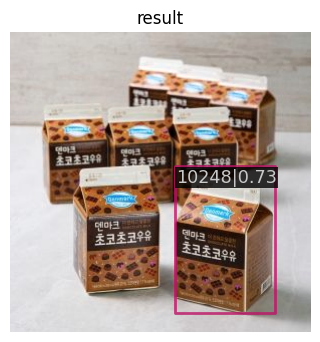

{'Milk': 1}

In [54]:
import json
result = inference_detector(model, img)

with open("./item.json", 'rt', encoding="UTF-8") as f:
    items = json.loads(f.read())

ret = {}
for (i, res) in zip(range(len(result)), result):
    if len(res) > 0:
        for arr in res:
            if arr[-1] > 0.3:
                if items[model.CLASSES[i]] not in ret.keys():
                    ret[items[model.CLASSES[i]]] = 1
                else:
                    ret[items[model.CLASSES[i]]] += 1
show_result_pyplot(model, img, result, score_thr=0.3)#score_thr
ret